#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 2 - Unsupervised Deep Learning
# Simone Trevisan 1238612

# Deonising autoencoder

## Dataset

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

Download the dataset:

In [2]:
trs = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True, transform=trs)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True, transform=trs)

Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw




Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Data Augmentation

In [3]:
# Data augmentation
trs2 = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(mode=None), 
                           torchvision.transforms.RandomAffine(35, translate=(0.12,0.12), shear=5), 
                           torchvision.transforms.ToTensor()])

In [4]:
train_dataset_aug_x = [trs2(tensor[0]) for tensor in train_dataset]
train_dataset_aug_y = [tensor[1] for tensor in train_dataset]

train_dataset_x = [tensor[0] for tensor in train_dataset]

In [5]:
train_dataset_x = torch.stack(train_dataset_x+train_dataset_aug_x)
train_dataset_y = torch.Tensor(train_dataset_aug_y+train_dataset_aug_y)

In [6]:
train_dataset = torch.utils.data.TensorDataset(train_dataset_x,train_dataset_y)

## Model Definition

Define the encoder:

In [7]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

Define the decoder:

In [8]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

Define the funtion to add random white gaussian noise:

In [9]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + (torch.randn(tensor.size()) * self.std + self.mean)*1*torch.mean(tensor)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

addNoiseTrs=transforms.Compose([
    torchvision.transforms.ToPILImage(mode=None),
    transforms.ToTensor(),
    AddGaussianNoise(0., 1.)
])

Define the training function:

In [10]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Add noise
        image_batch_noisy = [addNoiseTrs(tensor[0]) for tensor in image_batch]
        image_batch_noisy = torch.stack(image_batch_noisy)
        image_batch_noisy = image_batch_noisy.to(device)
        # Encode data
        encoded_data = encoder(image_batch_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))

Define the testing function:

In [11]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Add noise
            image_batch_noisy = [addNoiseTrs(tensor[0]) for tensor in image_batch]
            image_batch_noisy = torch.stack(image_batch_noisy)
            image_batch_noisy = image_batch_noisy.to(device)
            # Encode data
            encoded_data = encoder(image_batch_noisy)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

## Cross validation

In [24]:
def KfoldCV(k ,train_dataset,lr,decay,batchsize):
  losses = []
  i=1
  ### Define the loss function
  loss_fn = torch.nn.MSELoss()
  
  # Check if the GPU is available
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  
  # Initialize kfold
  kf = KFold(n_splits=k, shuffle=False)

  ### Training cycle
  for train_index, val_index in kf.split(train_dataset):
    ### Set the random seed for reproducible results
    torch.manual_seed(0)
    ### Initialize the two networks
    encoded_space_dim = 4
    encoder = Encoder(encoded_space_dim=encoded_space_dim)
    decoder = Decoder(encoded_space_dim=encoded_space_dim)
    encoder.to(device)
    decoder.to(device)
    params_to_optimize = [
      {'params': encoder.parameters()},
      {'params': decoder.parameters()}
    ]
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=decay)

    # Initialize dataloaders
    X_train = [train_dataset[t] for t in train_index]
    X_val = [train_dataset[v] for v in val_index]
    test_dataloader  = DataLoader(X_val,  batch_size=len(X_val), shuffle=False, num_workers=0)
    train_dataloader  = DataLoader(X_train,  batch_size=batchsize, shuffle=False, num_workers=0)

    num_epochs = 10
    for epoch in range(num_epochs):
        print('EPOCH %d/%d' % (epoch + 1, num_epochs))
        ### Training (use the training function)
        train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        ### Validation  (use the testing function)
        val_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn)
        # Print Validationloss
    print('\n\n\t VALIDATION - FOLD %d/%d - loss: %f\n\n' % (i,k, val_loss))
    losses.append(val_loss)
    i+=1
  results = {
      "lr" : lr,
      "decay" : decay,
      "batchsize" : batchsize,
      "mean val loss" : np.mean(losses)
  }

  return results

In [43]:
lr_grid = [1e-3, 1e-4]
decay_grid = [1e-6, 1e-5]
batchsize_grid = [256, 512]
models = []

train_subset=torch.utils.data.TensorDataset(train_dataset[range(int(len(train_dataset)/4),int(3*len(train_dataset)/4))][0],
                                            train_dataset[range(int(len(train_dataset)/4),int(3*len(train_dataset)/4))][1])

for lr in lr_grid:
  for decay in decay_grid:
    for batchsize in batchsize_grid:
      ris = KfoldCV(4,train_subset, lr, decay, batchsize)
      models.append(ris)

models = sorted(models, key=lambda k: k['mean val loss'])
print(models)
best_model = models[0]
best_model

EPOCH 1/10
EPOCH 2/10
EPOCH 3/10
EPOCH 4/10
EPOCH 5/10
EPOCH 6/10
EPOCH 7/10
EPOCH 8/10
EPOCH 9/10
EPOCH 10/10


	 VALIDATION - FOLD 1/4 - loss: 0.048886


EPOCH 1/10
EPOCH 2/10
EPOCH 3/10
EPOCH 4/10
EPOCH 5/10
EPOCH 6/10
EPOCH 7/10
EPOCH 8/10
EPOCH 9/10
EPOCH 10/10


	 VALIDATION - FOLD 2/4 - loss: 0.048642


EPOCH 1/10
EPOCH 2/10
EPOCH 3/10
EPOCH 4/10
EPOCH 5/10
EPOCH 6/10
EPOCH 7/10
EPOCH 8/10
EPOCH 9/10
EPOCH 10/10


	 VALIDATION - FOLD 3/4 - loss: 0.058332


EPOCH 1/10
EPOCH 2/10
EPOCH 3/10
EPOCH 4/10
EPOCH 5/10
EPOCH 6/10
EPOCH 7/10
EPOCH 8/10
EPOCH 9/10
EPOCH 10/10


	 VALIDATION - FOLD 4/4 - loss: 0.057100


EPOCH 1/10
EPOCH 2/10
EPOCH 3/10
EPOCH 4/10
EPOCH 5/10
EPOCH 6/10
EPOCH 7/10
EPOCH 8/10
EPOCH 9/10
EPOCH 10/10


	 VALIDATION - FOLD 1/4 - loss: 0.052051


EPOCH 1/10
EPOCH 2/10
EPOCH 3/10
EPOCH 4/10
EPOCH 5/10
EPOCH 6/10
EPOCH 7/10
EPOCH 8/10
EPOCH 9/10
EPOCH 10/10


	 VALIDATION - FOLD 2/4 - loss: 0.052546


EPOCH 1/10
EPOCH 2/10
EPOCH 3/10
EPOCH 4/10
EPOCH 5/10
EPOCH 6/1

{'batchsize': 256, 'decay': 1e-06, 'lr': 0.001, 'mean val loss': 0.053239994}

## Training loop

Best model from k-fold CV:

In [12]:
best_model = {
      "lr" : 1e-3,
      "decay" : 1e-6,
      "batchsize" : 256,
      "mean val loss" : 0.053239994
  }

Initialize the network:

In [13]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 4
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = best_model["lr"] # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=best_model["decay"])

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = best_model["batchsize"], shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 1000, shuffle = False)

Selected device: cuda


Training phase:

EPOCH 1/40


	 VALIDATION - EPOCH 1/40 - loss: 0.055437




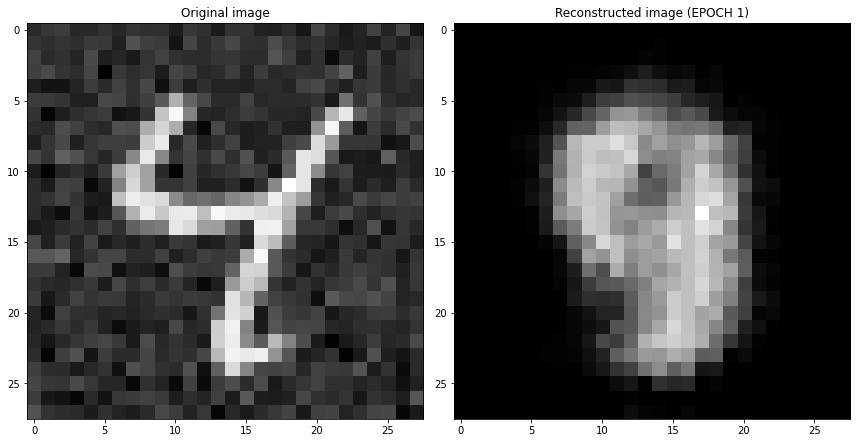

EPOCH 2/40


	 VALIDATION - EPOCH 2/40 - loss: 0.045579




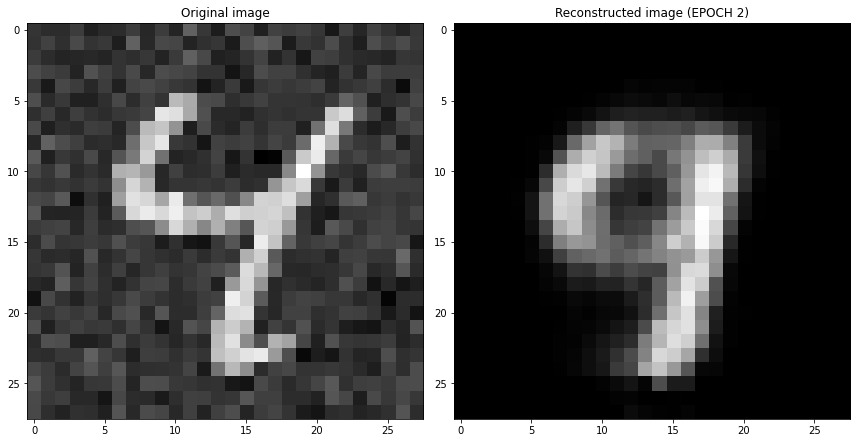

EPOCH 3/40


	 VALIDATION - EPOCH 3/40 - loss: 0.040833




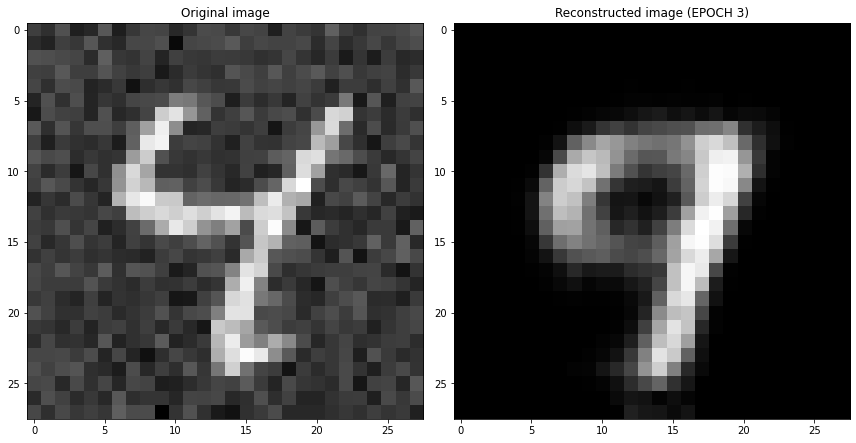

EPOCH 4/40


	 VALIDATION - EPOCH 4/40 - loss: 0.038598




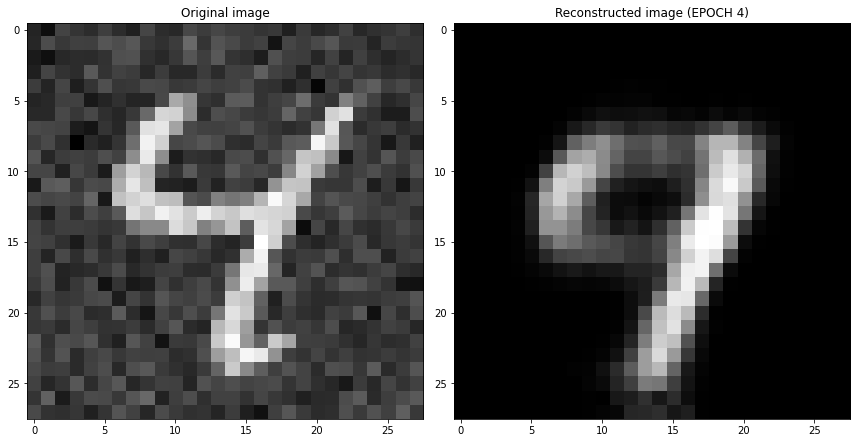

EPOCH 5/40


	 VALIDATION - EPOCH 5/40 - loss: 0.037007




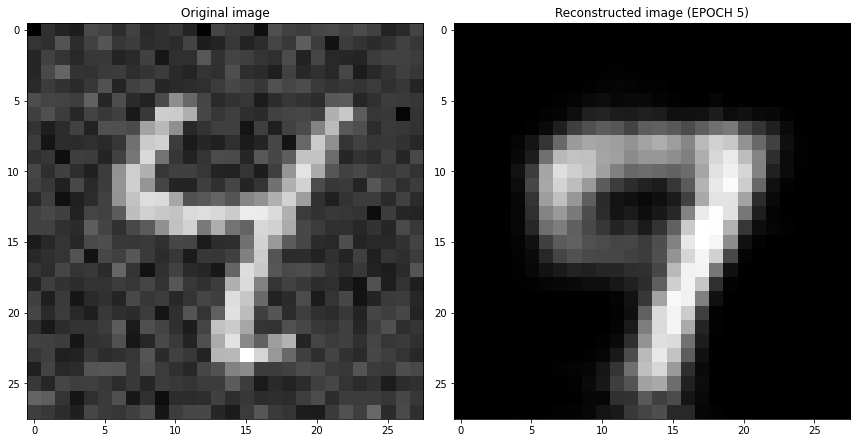

EPOCH 6/40


	 VALIDATION - EPOCH 6/40 - loss: 0.035902




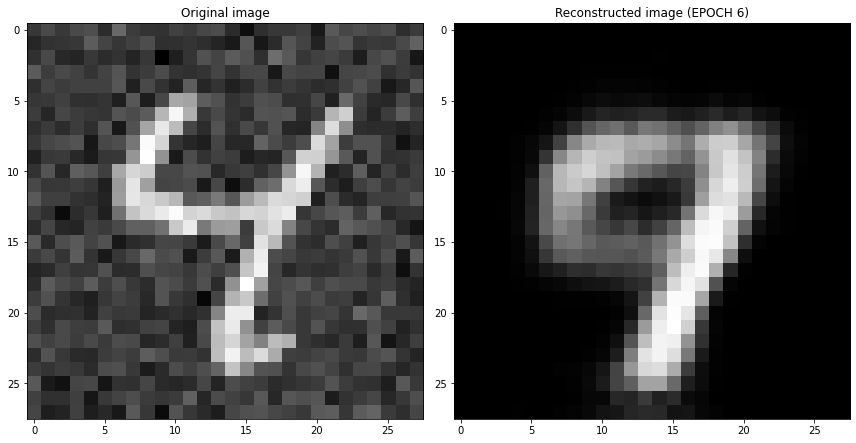

EPOCH 7/40


	 VALIDATION - EPOCH 7/40 - loss: 0.035255




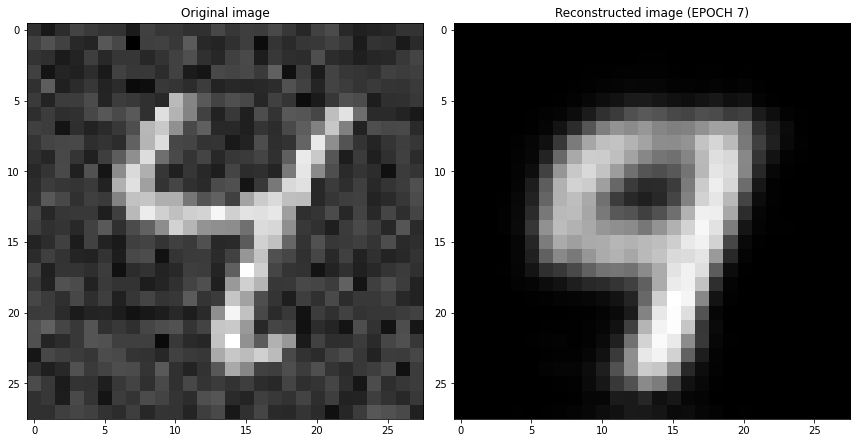

EPOCH 8/40


	 VALIDATION - EPOCH 8/40 - loss: 0.034890




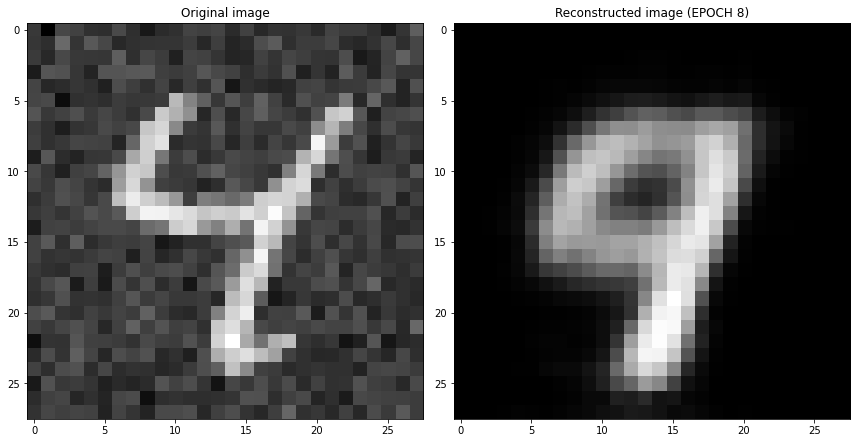

EPOCH 9/40


	 VALIDATION - EPOCH 9/40 - loss: 0.034513




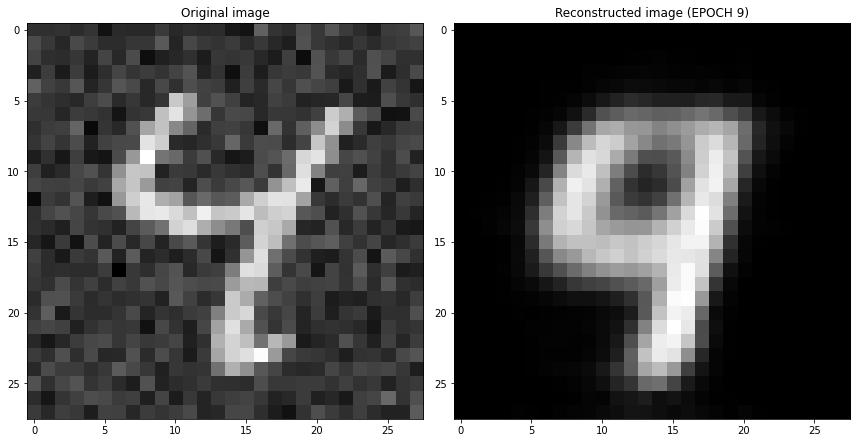

EPOCH 10/40


	 VALIDATION - EPOCH 10/40 - loss: 0.034007




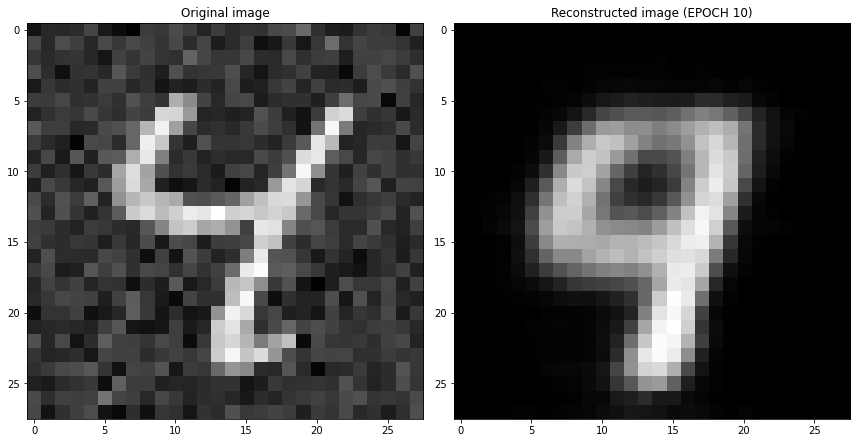

EPOCH 11/40


	 VALIDATION - EPOCH 11/40 - loss: 0.033816




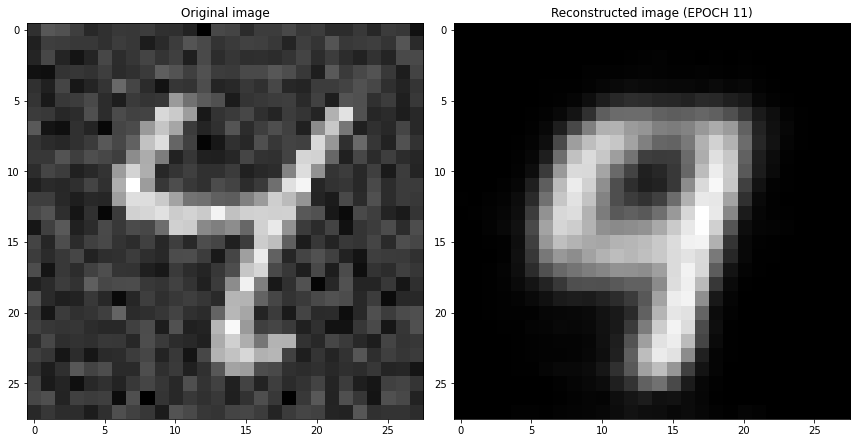

EPOCH 12/40


	 VALIDATION - EPOCH 12/40 - loss: 0.033480




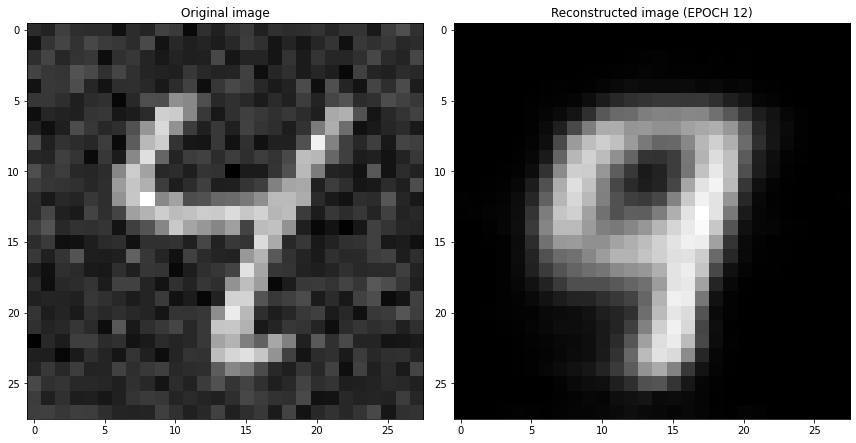

EPOCH 13/40


	 VALIDATION - EPOCH 13/40 - loss: 0.033252




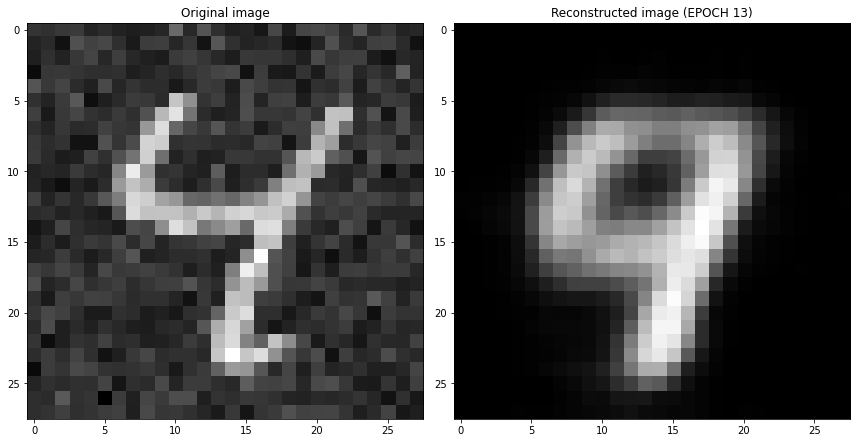

EPOCH 14/40


	 VALIDATION - EPOCH 14/40 - loss: 0.033050




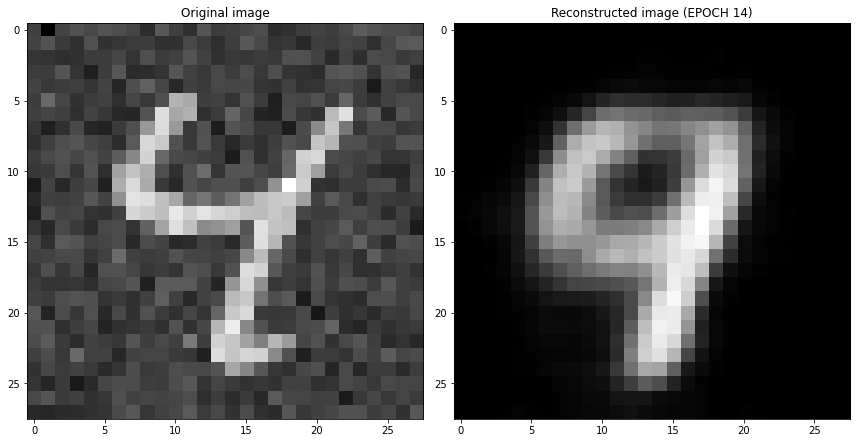

EPOCH 15/40


	 VALIDATION - EPOCH 15/40 - loss: 0.033215




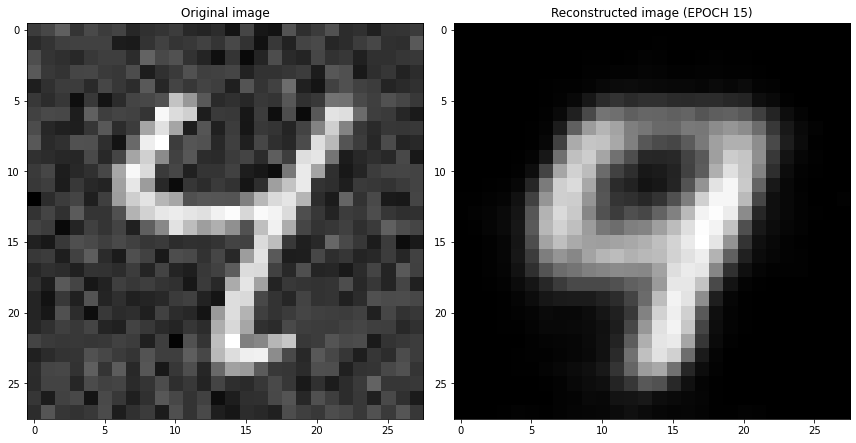

EPOCH 16/40


	 VALIDATION - EPOCH 16/40 - loss: 0.032747




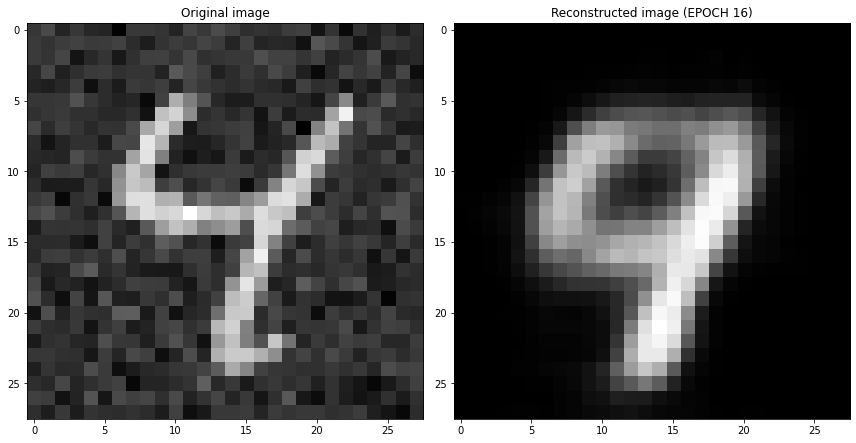

EPOCH 17/40


	 VALIDATION - EPOCH 17/40 - loss: 0.032484




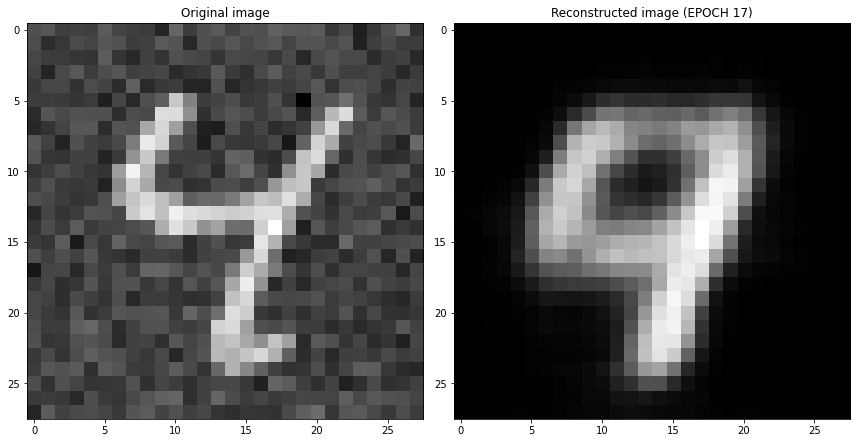

EPOCH 18/40


	 VALIDATION - EPOCH 18/40 - loss: 0.032516




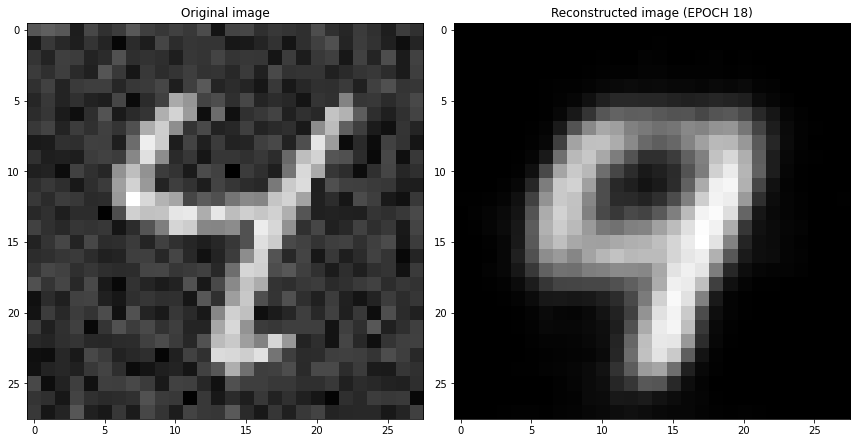

EPOCH 19/40


	 VALIDATION - EPOCH 19/40 - loss: 0.032207




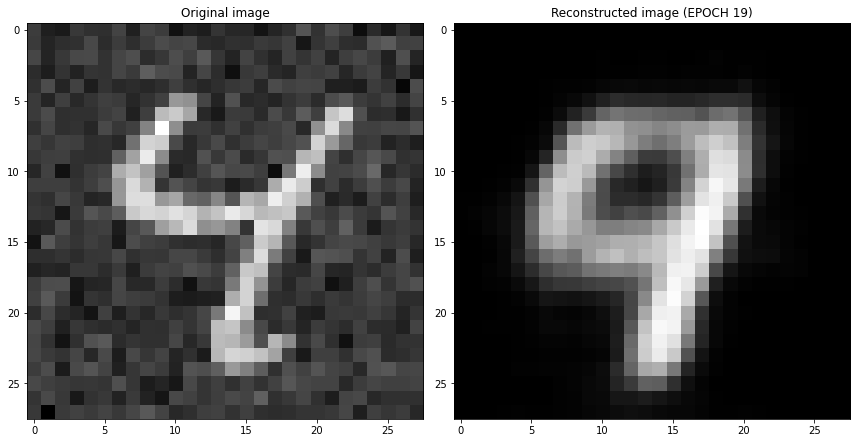

EPOCH 20/40


	 VALIDATION - EPOCH 20/40 - loss: 0.032288




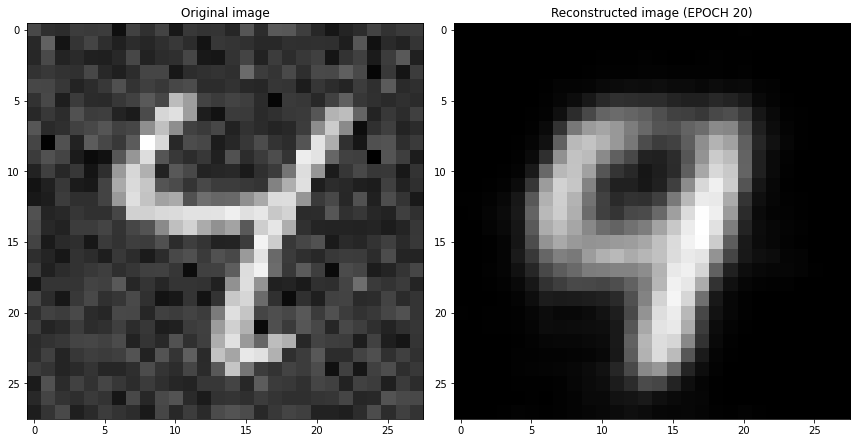

EPOCH 21/40


	 VALIDATION - EPOCH 21/40 - loss: 0.031933




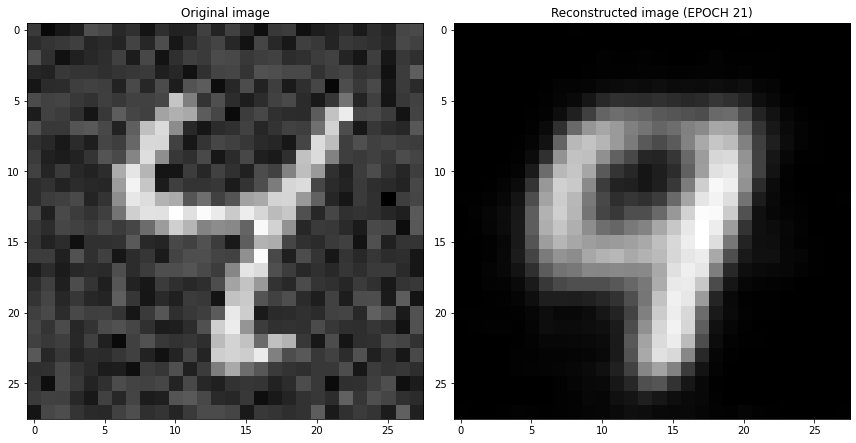

EPOCH 22/40


	 VALIDATION - EPOCH 22/40 - loss: 0.031780




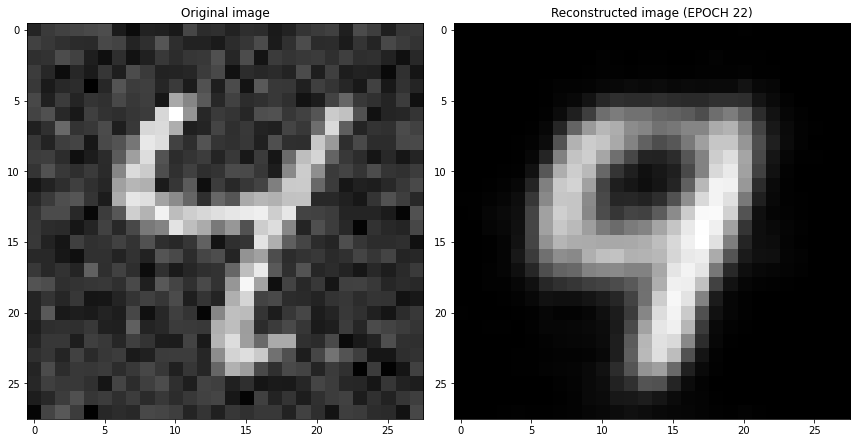

EPOCH 23/40


	 VALIDATION - EPOCH 23/40 - loss: 0.031903




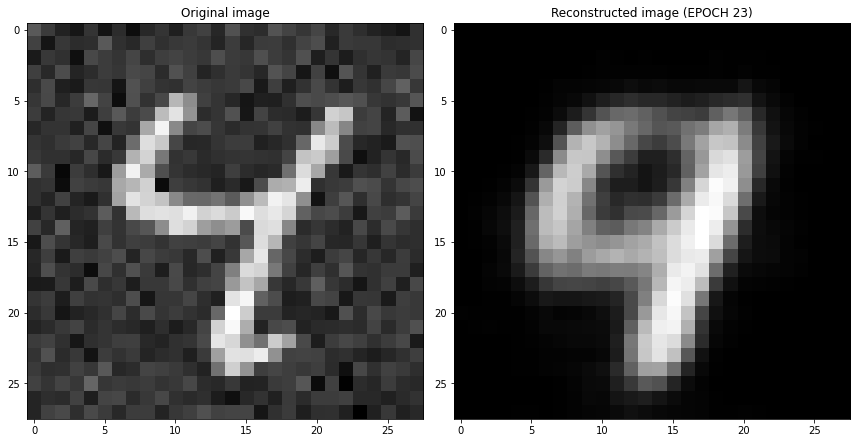

EPOCH 24/40


	 VALIDATION - EPOCH 24/40 - loss: 0.031930




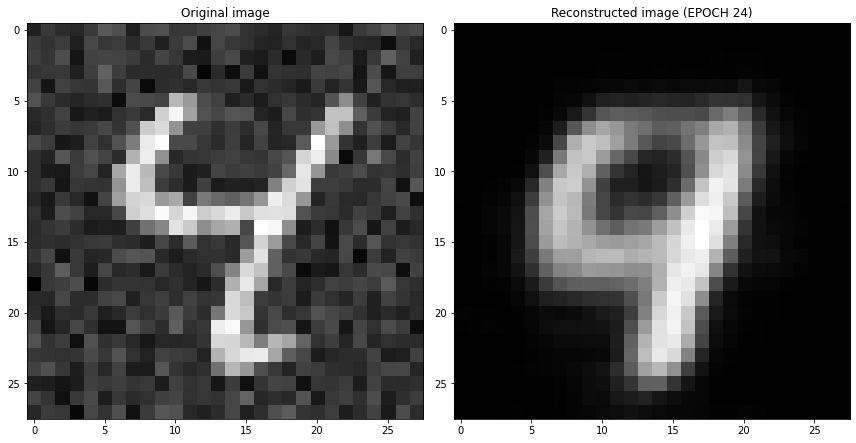

EPOCH 25/40


	 VALIDATION - EPOCH 25/40 - loss: 0.031661




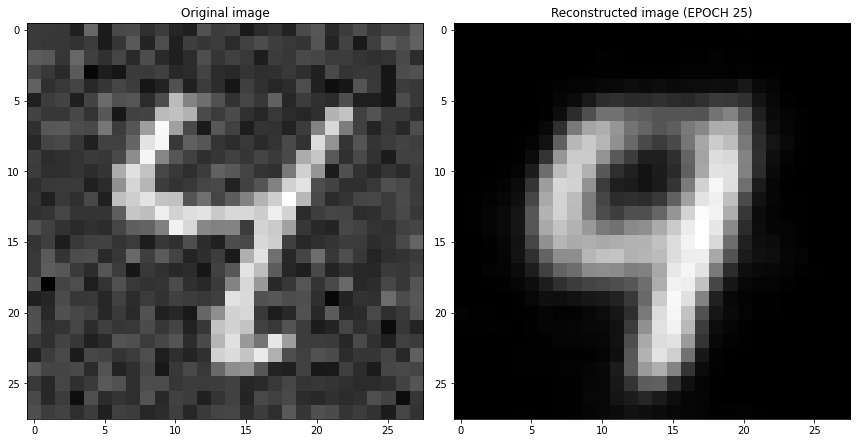

EPOCH 26/40


	 VALIDATION - EPOCH 26/40 - loss: 0.031519




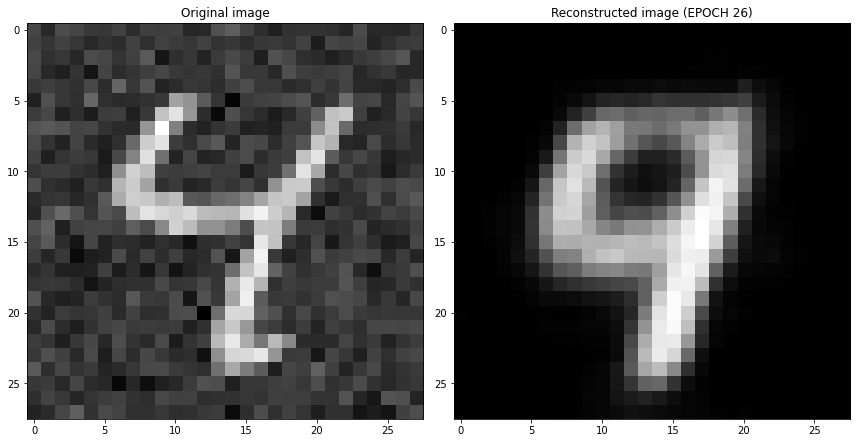

EPOCH 27/40


	 VALIDATION - EPOCH 27/40 - loss: 0.031570




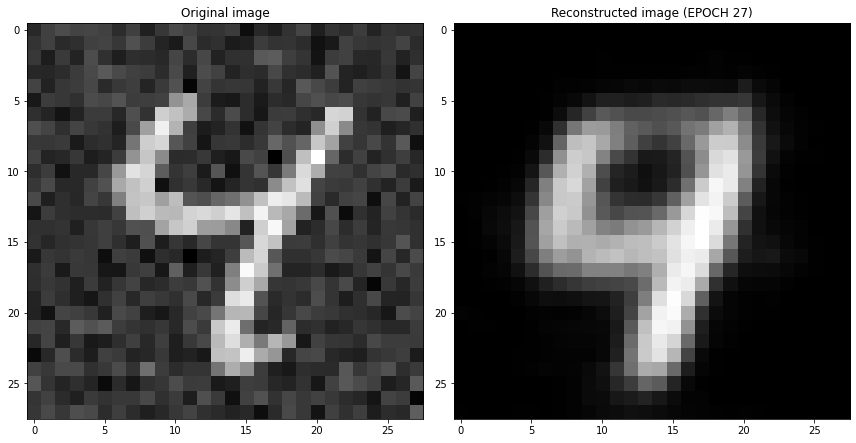

EPOCH 28/40


	 VALIDATION - EPOCH 28/40 - loss: 0.031563




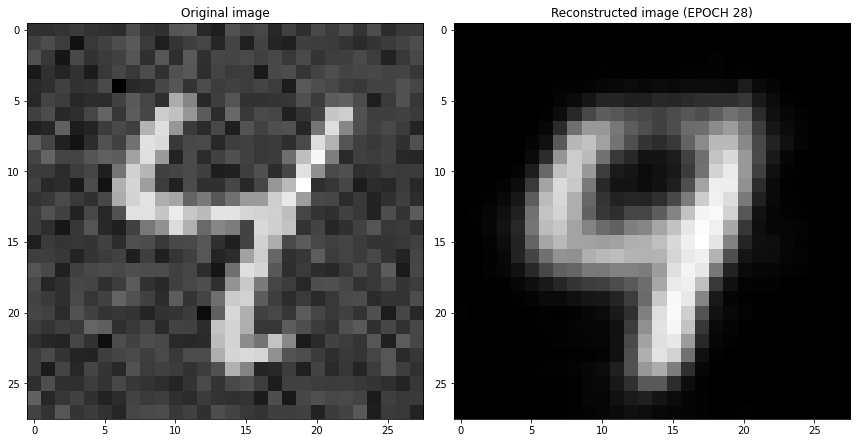

EPOCH 29/40


	 VALIDATION - EPOCH 29/40 - loss: 0.031473




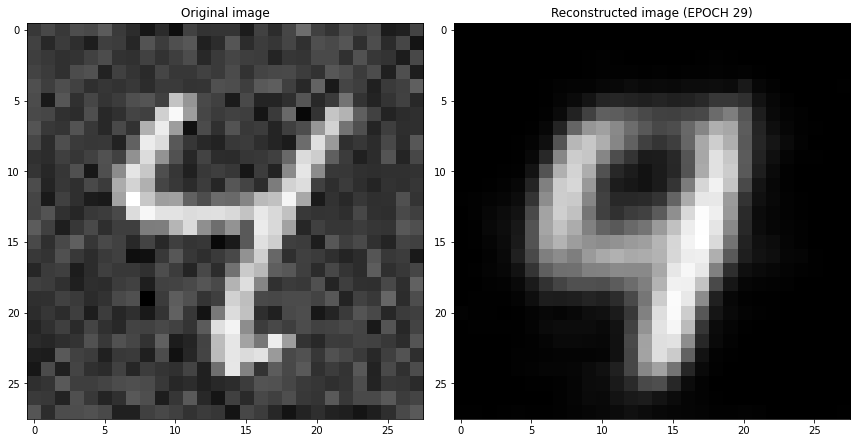

EPOCH 30/40


	 VALIDATION - EPOCH 30/40 - loss: 0.031380




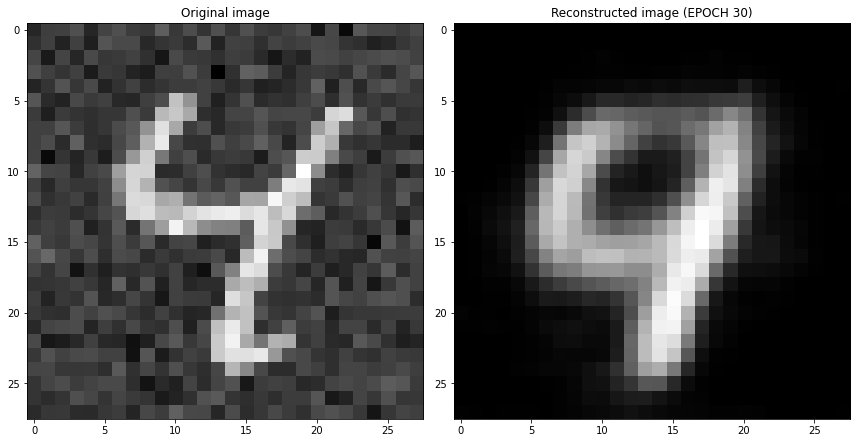

EPOCH 31/40


	 VALIDATION - EPOCH 31/40 - loss: 0.031353




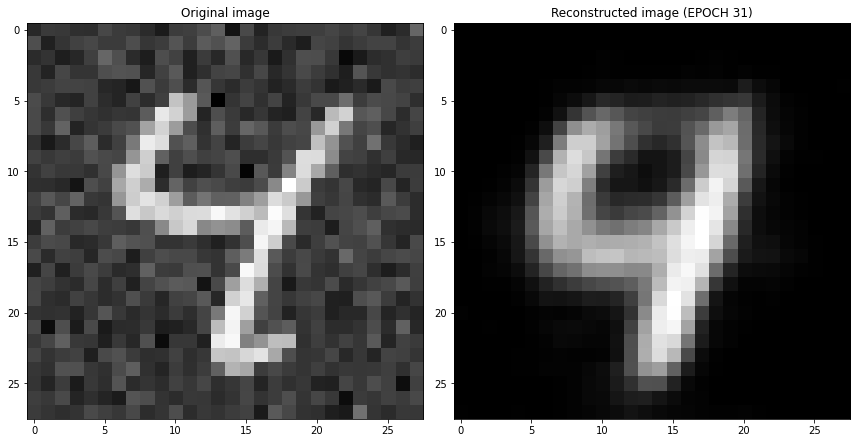

EPOCH 32/40


	 VALIDATION - EPOCH 32/40 - loss: 0.031262




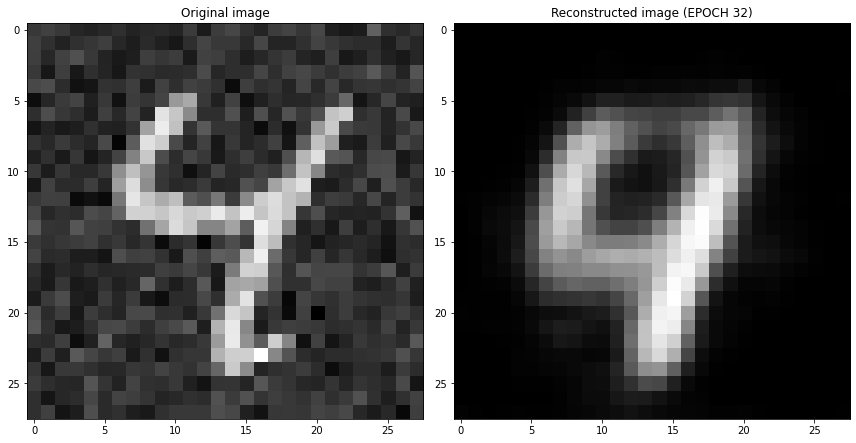

EPOCH 33/40


	 VALIDATION - EPOCH 33/40 - loss: 0.031072




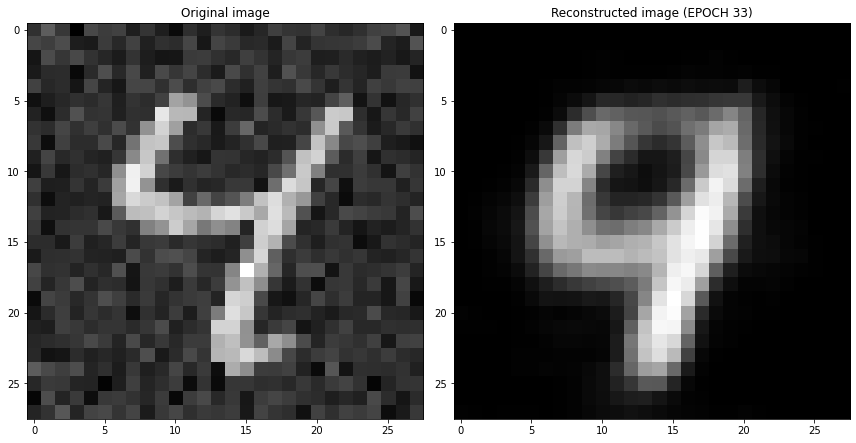

EPOCH 34/40


	 VALIDATION - EPOCH 34/40 - loss: 0.031116




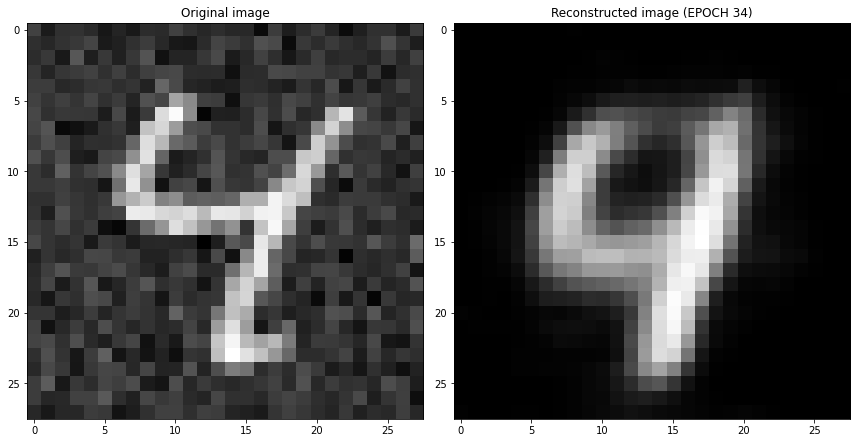

EPOCH 35/40


	 VALIDATION - EPOCH 35/40 - loss: 0.031290




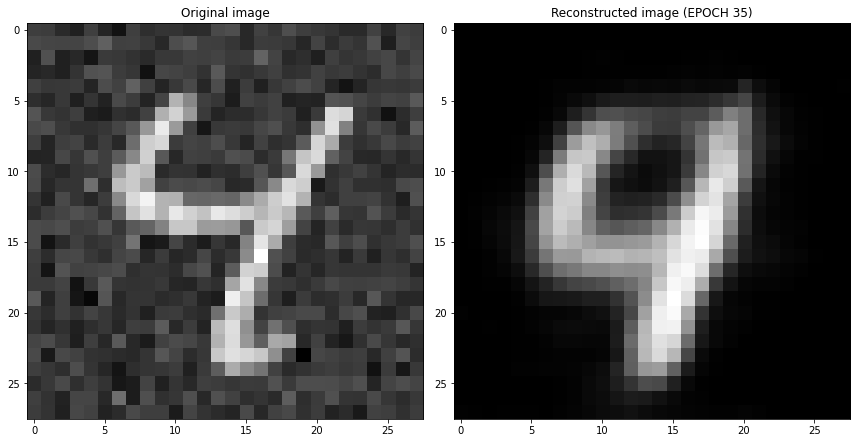

EPOCH 36/40


	 VALIDATION - EPOCH 36/40 - loss: 0.030825




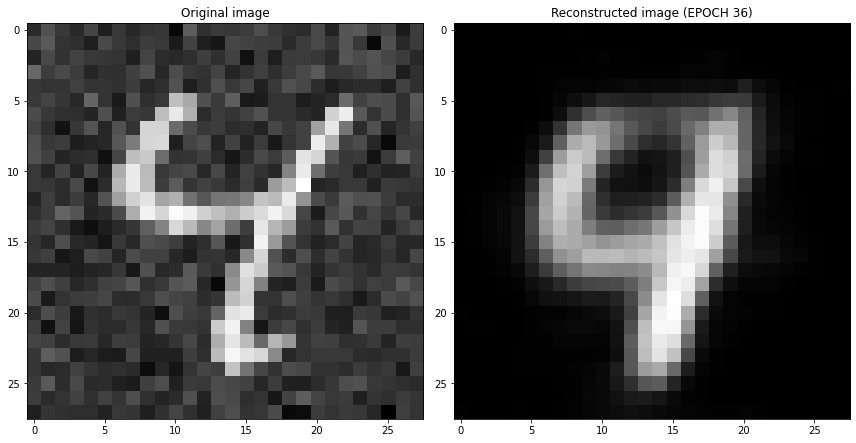

EPOCH 37/40


	 VALIDATION - EPOCH 37/40 - loss: 0.030861




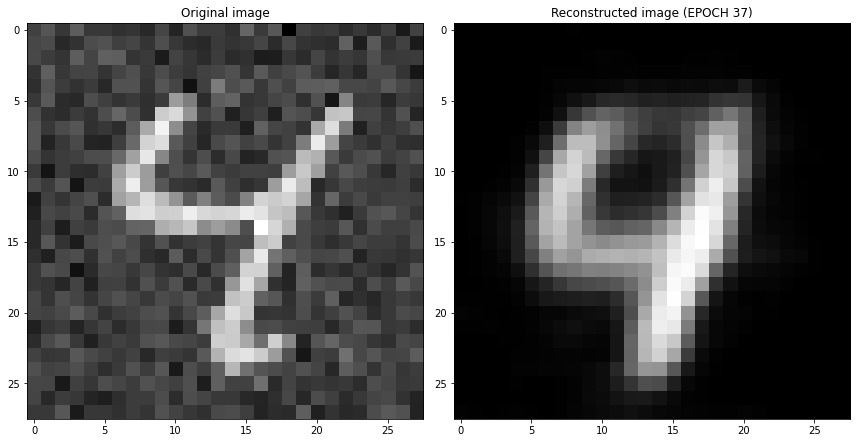

EPOCH 38/40


	 VALIDATION - EPOCH 38/40 - loss: 0.030838




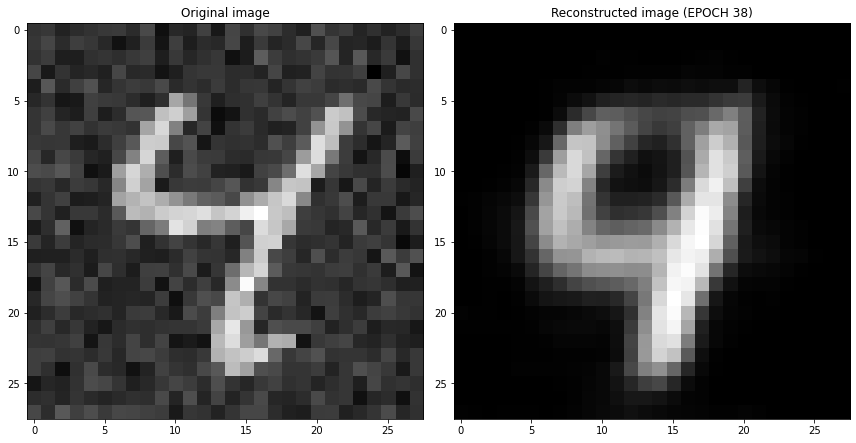

EPOCH 39/40


	 VALIDATION - EPOCH 39/40 - loss: 0.030786




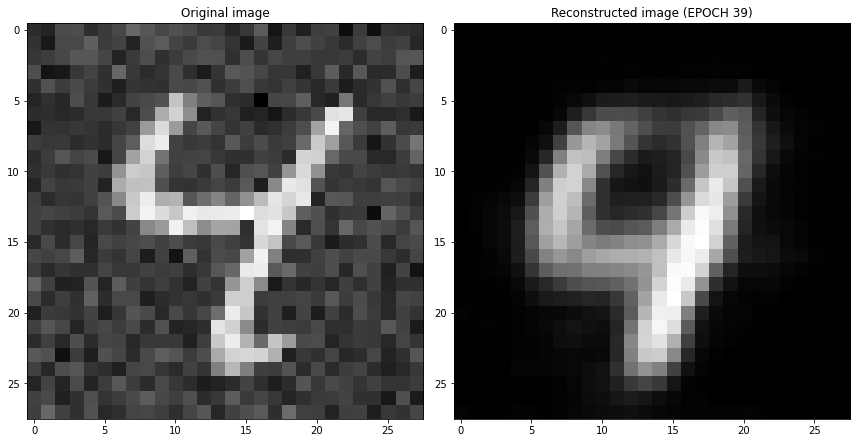

EPOCH 40/40


	 VALIDATION - EPOCH 40/40 - loss: 0.030887




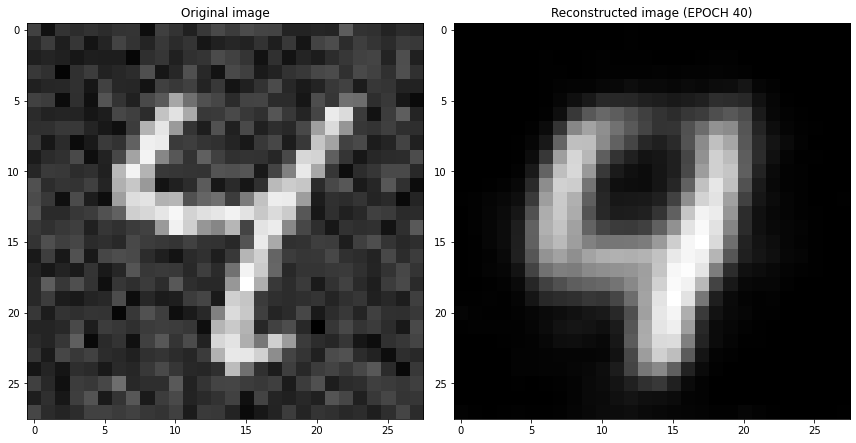

In [14]:
### Training cycle
val_loss_conc=[]
num_epochs = 40
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    val_loss_conc.append(val_loss)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[6][0].unsqueeze(0).to(device)
    img_n = addNoiseTrs(test_dataset[6][0]).unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img_n))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img_n.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(encoder.state_dict(), 'encoder_params.pth')
    torch.save(decoder.state_dict(), 'decoder_params.pth')

    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

No handles with labels found to put in legend.


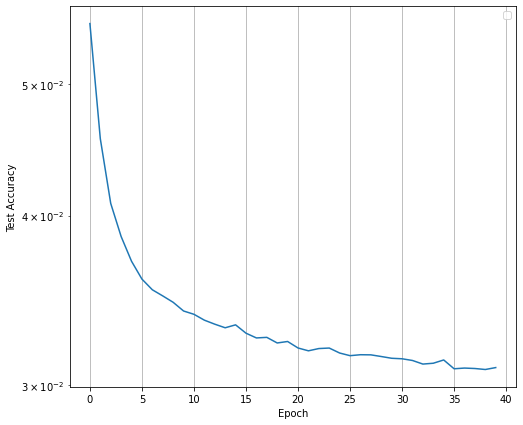

In [35]:
plt.figure(figsize=(8,7))
plt.semilogy(val_loss_conc)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.grid()
plt.legend()
plt.show()

## Network Analysis

In [17]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

Plot a sample of denoising-reconstruction from test set:

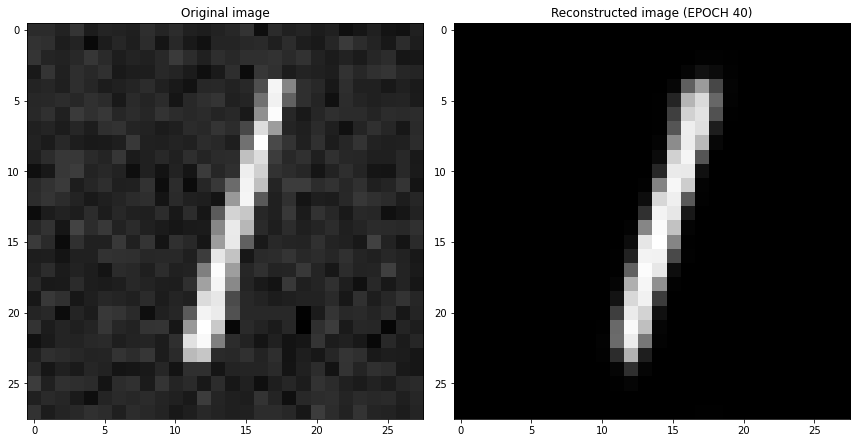

In [18]:
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[6][0].unsqueeze(0).to(device)
    img_n = addNoiseTrs(test_dataset[2][0]).unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img_n))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img_n.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

Reduce the dimensionality of the latent space to plot it, using PCA:

In [20]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:07<00:00, 1270.39it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-8.025657,17.112961,-45.224407,6.047551,7
1,-1.507951,3.173859,4.893966,-1.927571,2
2,-18.109829,8.539167,-3.910287,-3.842474,1
3,1.936334,-9.912207,-7.848522,3.441313,0
4,-3.121830,2.748121,-5.825913,5.101065,4
...,...,...,...,...,...
9995,-6.550570,-1.631469,9.863083,-5.102165,2
9996,-0.035280,3.115431,1.177665,1.117213,3
9997,-7.435933,3.825645,-9.244185,1.247233,4
9998,-3.445926,-1.196108,-1.063498,-0.549674,5


In [21]:
features = ['Enc. Variable 0', 'Enc. Variable 1', 'Enc. Variable 2', 'Enc. Variable 3']
# Separating out the features
x = encoded_samples.loc[:, features].values
# Separating out the target
y = encoded_samples.loc[:,['label']].values


from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, encoded_samples[['label']]], axis = 1)

In [22]:
import plotly.express as px
px.scatter(finalDf, x='principal component 1', y='principal component 2', color=encoded_samples.label.astype(str), opacity=0.7)

## Supervised classification task

Define the classification layer:

In [24]:
class Classifier(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.classifier = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 256),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(256, 10)
        )

        
    def forward(self, x):
        # Apply linear layers
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

Redefine the train and test functions:

In [25]:
### Training function
def train_class(encoder, classifier, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    classifier.train()
    # Iterate the dataloader
    for image_batch, label_batch in dataloader:
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        label_batch = torch.tensor(label_batch, dtype=torch.long, device=device)
        # Add noise
        image_batch_noisy = [addNoiseTrs(tensor[0]) for tensor in image_batch]
        image_batch_noisy = torch.stack(image_batch_noisy)
        image_batch_noisy = image_batch_noisy.to(device)
        # Encode data
        encoded_data = encoder(image_batch_noisy)
        # Classify data
        out = classifier(encoded_data)
        # Evaluate 
        loss = F.nll_loss(out, label_batch.squeeze())
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))

In [26]:
### Testing function
def test_class(encoder, classifier, device, dataloader):
    # Set evaluation mode for encoder and decoder
    correct=0
    encoder.eval()
    classifier.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        for image_batch, label_batch in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            label_batch = torch.tensor(label_batch, dtype=torch.long, device=device)
            # Add noise
            image_batch_noisy = [addNoiseTrs(tensor[0]) for tensor in image_batch]
            image_batch_noisy = torch.stack(image_batch_noisy)
            image_batch_noisy = image_batch_noisy.to(device)
            # Encode data
            encoded_data = encoder(image_batch_noisy)
            # Classify data
            out = classifier(encoded_data)
            predicted = torch.max(out, 1)[1]
            # Append the network output and the original image to the lists
            correct += (predicted == label_batch.T).sum()

        # Compute accuracy
        accuracy = float(correct*100) / float(10000)

    return accuracy

Initialize the network:

In [27]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 4
classifier = Classifier(encoded_space_dim=encoded_space_dim)

class_params = [
                {'params': encoder.parameters(), 'lr': 1e-4},
                {'params': classifier.parameters(), 'lr': 1e-3}
            ]

optim2 = torch.optim.Adam(class_params, lr=1e-4, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move both the encoder and the decoder to the selected device
encoder.to(device)
classifier.to(device)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 256, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 1000, shuffle = False)

Train the network:

In [28]:
### Training cycle
num_epochs = 10
for epoch in range(num_epochs):
    ### Training (use the training function)
    train_class(
        encoder=encoder, 
        classifier=classifier, 
        device=device, 
        dataloader=train_dataloader, 
        optimizer=optim2)
    ### Validation  (use the testing function)
    accuracy = test_class(
        encoder=encoder, 
        classifier=classifier, 
        device=device, 
        dataloader=test_dataloader)
    # Print Validationloss
    #print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))
    print('Epoch : {} \t Accuracy:{:.3f}%'.format(
                epoch+1,
                accuracy))


    # Save network parameters
    torch.save(encoder.state_dict(), 'ref_encoder_params.pth')
    torch.save(classifier.state_dict(), 'classifier_params.pth')

    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch : 1 	 Accuracy:89.600%
Epoch : 2 	 Accuracy:93.310%
Epoch : 3 	 Accuracy:94.690%
Epoch : 4 	 Accuracy:95.360%
Epoch : 5 	 Accuracy:95.760%
Epoch : 6 	 Accuracy:96.320%
Epoch : 7 	 Accuracy:96.310%
Epoch : 8 	 Accuracy:96.590%
Epoch : 9 	 Accuracy:96.510%
Epoch : 10 	 Accuracy:96.810%


Perform the same analysis made for the autoencoder latent space:

In [29]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:07<00:00, 1275.62it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-0.222235,17.302332,-34.724648,2.155928,7
1,0.566089,1.364440,5.478656,-6.561831,2
2,-7.195492,2.273841,-2.651592,-0.618830,1
3,1.888914,-7.940903,-5.531823,1.202798,0
4,-3.750612,-0.227376,-5.623632,5.430038,4
...,...,...,...,...,...
9995,-1.184750,-0.251322,8.871460,-10.773453,2
9996,3.310348,2.135171,3.185480,0.540130,3
9997,-5.439931,1.245087,-6.668960,5.238662,4
9998,-0.865394,-3.093951,2.111989,3.350428,5


In [31]:
features = ['Enc. Variable 0', 'Enc. Variable 1', 'Enc. Variable 2', 'Enc. Variable 3']
# Separating out the features
x = encoded_samples.loc[:, features].values
# Separating out the target
y = encoded_samples.loc[:,['label']].values


from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, encoded_samples[['label']]], axis = 1)

In [32]:
px.scatter(finalDf, x='principal component 1', y='principal component 2', color=encoded_samples.label.astype(str), opacity=0.7)